# LDA (Latent Dirichlet Allocation) for Topic Modeling - Problem 1

- **Each file as a document**: each row of the dataframe contains all the comments in one contents.csv file. 
- In this case, there are 1385 documents in total, which is a moderate data size, thus I used the **'batch'** learning method here.

The reason of choosing **'batch'** method is shown below:

**learning_method** : ‘batch’ | ‘online’, default=’batch’
- Method used to update `_component`. Only used in fit method. 
- In general, if the data size is **large**, the **'online'** update will be much faster than the batch update.
- **'batch'**: Batch variational Bayes method. Use all training data in
    each EM update.
    Old `components_` will be overwritten in each iteration.
- **'online'**: Online variational Bayes method. In each EM update, use
    mini-batch of training data to update the ``components_``
    variable incrementally. The learning rate is controlled by the
    ``learning_decay`` and the ``learning_offset`` parameters.

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import spacy
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored, cprint
import joblib

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.spatial.distance import pdist
from ipywidgets import interact, FloatSlider

In [5]:
from pathlib import Path
import os

In [6]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)
pyLDAvis.enable_notebook()
pd.options.display.float_format = '{:,.2f}'.format

## 1. Load Data & Construct Dataframe

In [7]:
os.getcwd()

'D:\\Uchicago_Courses\\[!] FINM33165 - Probabilistic Programming and Deep Learning (Niels O Nygaard)\\HW2'

In [9]:
path = Path(os.getcwd())
data_path = path/'data_parsed'
data_path

WindowsPath('D:/Uchicago_Courses/[!] FINM33165 - Probabilistic Programming and Deep Learning (Niels O Nygaard)/HW2/data_parsed')

In [10]:
# folder names
os.listdir(path=data_path)[:10]

['A', 'AAC', 'AAIGF', 'AAP', 'AAUKF', 'AAXN', 'ABDC', 'ABEO', 'ABEV', 'ABM']

In [11]:
files = data_path.glob(r'**/contents.csv')
data_list = []
for file in files:
    folder_name = file.parts[-2]
    contents = pd.read_csv(file)['content'].values.tolist()
    all_contents = ''
    for i in range(len(contents)):
        if contents[i] is not np.nan:
            all_contents = all_contents + contents[i]
    data_list.append([folder_name, all_contents])

docs = pd.DataFrame(data_list, columns=['folder_name','article'])  

In [12]:
docs.head()

,folder_name,article
0,A,"Thank you, Mike, and welcome, everyone, to Agi..."
1,AAC,"Good morning, and welcome to our earnings conf..."
2,AAIGF,Thanks Lance. Good morning everyone. I’m delig...
3,AAP,Good morning and thank you for joining us to d...
4,AAUKF,"Thanks, Stuart, and good morning, ladies and g..."


In [13]:
n_docs = len(docs)
n_docs

1385

In [14]:
docs.iloc[0]['article']

"Thank you, Mike, and welcome, everyone, to Agilent's third quarter conference call for fiscal year 2019. With me are Mike McMullen, Agilent's President and CEO; and Bob McMahon, Agilent's Senior Vice President and CFO. Joining in the Q&A after Bob's comments will be Jacob Thaysen, President of Agilent's Life Science and Applied Markets Group; Sam Raha, President of Agilent's Diagnostics and Genomics Group; and Mark Doak, President of Agilent's CrossLab Group.You can find the press release, investor presentation and information to supplement today's discussion on our website at investor.agilent.com. Today's comments by Mike and Bob will refer to non-GAAP financial measures. You will find the most directly comparable GAAP financial metrics and reconciliations on our website. Unless otherwise noted, all references to increases or decreases in financial metrics are year-over-year. References to revenue growth are on a core basis. Core revenue growth excludes the impact of currency and the

## 2. Vectorizer & DTM

In [15]:
train_docs, test_docs = train_test_split(docs, 
                                         test_size=50, 
                                         random_state=42)

In [16]:
train_docs.shape, test_docs.shape

((1335, 2), (50, 2))

In [17]:
vectorizer = CountVectorizer(max_df=.3, min_df=.01, stop_words='english',
                             binary='False', ngram_range=(1,2))      # include single tokens & pairs of tokens

In [18]:
train_dtm = vectorizer.fit_transform(train_docs['article'])

In [19]:
len(vectorizer.vocabulary_)

28923

In [20]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
words = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)

In [21]:
word_count.head(10)

marketplace      400
forecast         400
digital          400
sustainable      400
partnership      400
savings          399
needed           399
question just    399
okay thanks      399
excellent        399
dtype: int64

In [22]:
train_dtm

<1335x28923 sparse matrix of type '<class 'numpy.int64'>'
	with 1347973 stored elements in Compressed Sparse Row format>

In [23]:
test_dtm = vectorizer.transform(test_docs['article'])

In [24]:
test_dtm

<50x28923 sparse matrix of type '<class 'numpy.int64'>'
	with 48239 stored elements in Compressed Sparse Row format>

## 3. Use 5 Topics

### lda_base model with 'batch' method (5)

In [25]:
n_components = 5

In [26]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1)
lda_base.fit(train_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 18919.3085
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 18736.1374
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 18695.7412
iterati

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [27]:
topics_count = lda_base.components_

In [28]:
topics_count.shape

(5, 28923)

In [29]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[1.56094621e-05, 6.49144350e-05, 7.82780911e-07, ...,
        2.09981995e-04, 1.33000019e-04, 7.98081280e-07],
       [8.54072459e-05, 6.59645798e-07, 6.17452157e-05, ...,
        6.60232008e-07, 6.65391354e-07, 7.51861507e-06],
       [1.23021044e-05, 1.37164303e-05, 1.78159962e-06, ...,
        5.14817884e-05, 1.78091875e-06, 1.78633428e-06],
       [2.15887708e-05, 2.22955226e-05, 3.17036207e-07, ...,
        1.70254219e-05, 9.19650567e-06, 6.86781299e-06],
       [3.74380854e-06, 3.69470357e-06, 3.79585255e-06, ...,
        3.46111830e-05, 2.52197562e-05, 1.44851722e-04]])

In [30]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
00,0.00,0.00,0.00,0.00,0.00
000 000,0.00,0.00,0.00,0.00,0.00
000 01,0.00,0.00,0.00,0.00,0.00
000 02,0.00,0.00,0.00,0.00,0.00
000 10,0.00,0.00,0.00,0.00,0.00


In [31]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,plant,compared million,patients,digital,yield
1,construction,2019 compared,clinical,category,loan
2,maintenance,12 million,patient,channel,mortgage
3,facilities,11 million,medical,piece,returns
4,recovery,commission,fda,helping,weighted
5,2021,gross profit,study,ve talked,property
6,oil,period year,treatment,categories,underwriting
7,energy,attributable,trial,eps,real estate
8,operation,quarter million,research,marketplace,loans
9,equipment,equivalents,trials,couple years,estate


### Topics Distributions & Heatmap (5)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


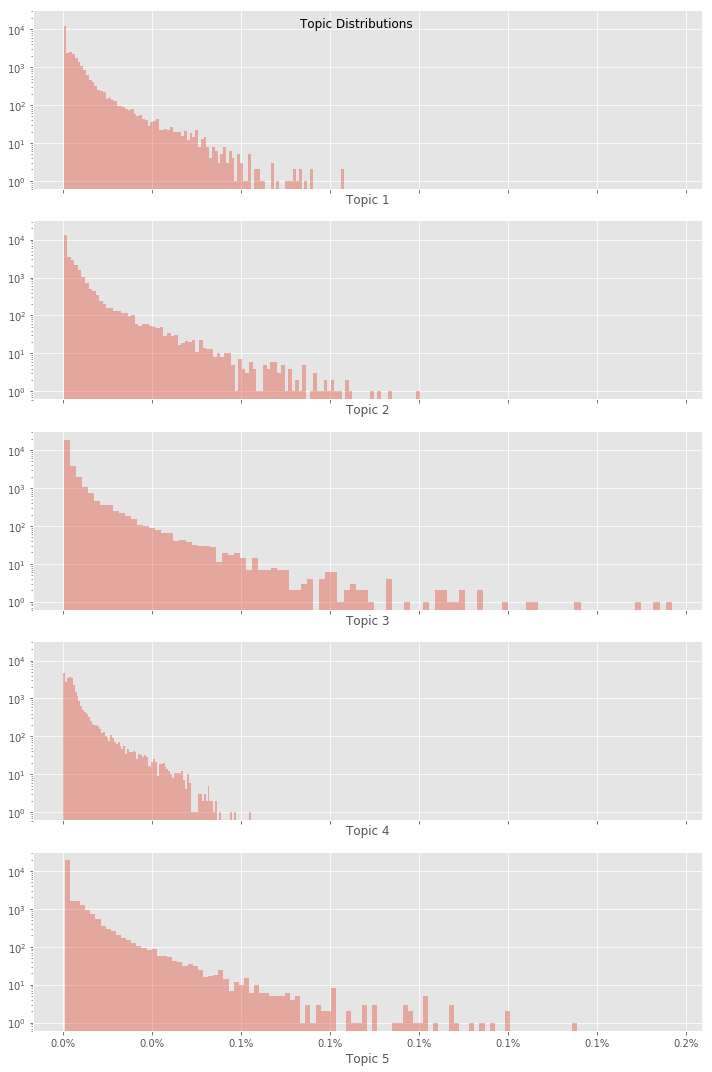

In [32]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(10,15))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

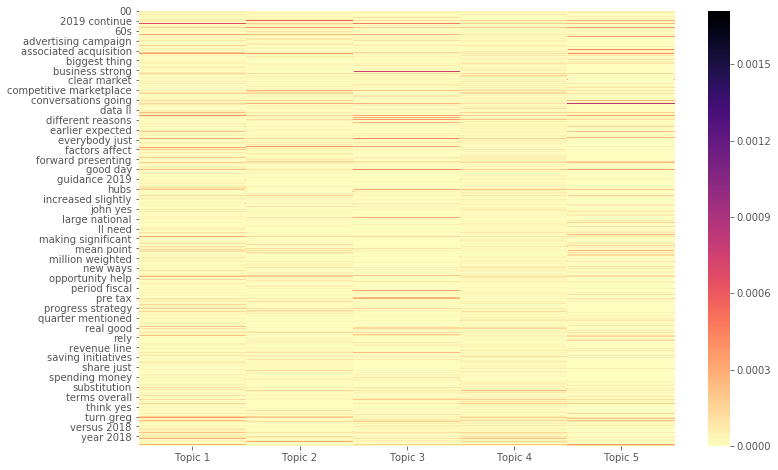

In [33]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (5)

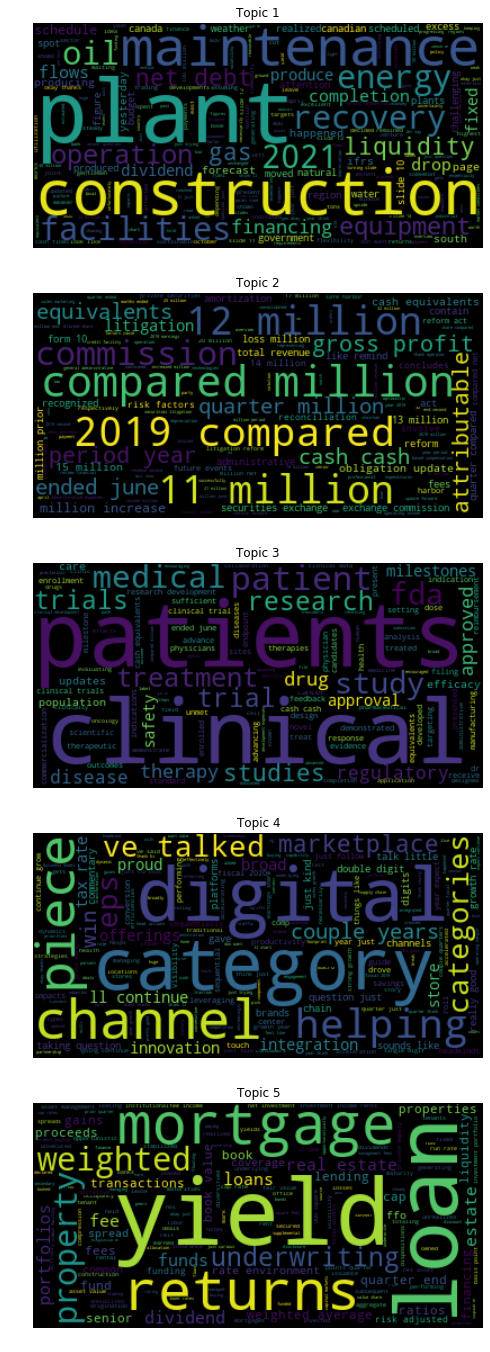

In [34]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(12,24))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (5)

In [35]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(1335, 5)

In [36]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [37]:
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.44,0.21,0.00,0.35,0.00
1,0.00,0.65,0.00,0.35,0.00
2,0.00,0.00,0.00,1.00,0.00
3,0.00,0.16,0.00,0.84,0.00
4,0.15,0.25,0.00,0.60,0.00


In [38]:
test_preds = lda_base.transform(test_dtm)
test_preds.shape

(50, 5)

In [39]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.25,0.35,0.00,0.40,0.00
1,0.55,0.06,0.00,0.36,0.03
2,0.00,0.41,0.43,0.16,0.00
3,0.00,0.29,0.00,0.71,0.00
4,0.04,0.16,0.50,0.30,0.00


### Perplexity (5)

In [40]:
lda_base.perplexity(train_dtm)

18657.699599462125

In [41]:
lda_base.perplexity(test_dtm)

733179.8923188996

### Cluster Graphs using PyLDAvis.prepare (5)

In [42]:
prepare(lda_base, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
3     -0.02 -0.01       1        1 45.85
1      0.12  0.13       2        1 26.89
0     -0.06 -0.09       3        1 17.39
2      0.12 -0.10       4        1  8.70
4     -0.16  0.06       5        1  1.17, topic_info=      Category  Freq              Term  Total  loglift  logprob
22278  Default 11.00           returns  11.00    30.00    30.00
10103  Default 12.00             gains  12.00    29.00    29.00
9367   Default 14.00              fees  14.00    28.00    28.00
28014  Default  9.00          weighted   9.00    27.00    27.00
14532  Default 10.00              loan  10.00    26.00    26.00
7527   Default 10.00          dividend  10.00    25.00    25.00
28906  Default  8.00             yield   8.00    24.00    24.00
26812  Default 11.00      transactions  11.00    23.00    23.00
9491   Default 12.00         financing  12.00    22.00    22.00
14371  Default 11.00         liquidity  11.00    21.00    21.00
9991   Default 11.00              fund  11.00    20.00    20.00
3477   Default  9.00              book   9.00    19.00    19.00
23468  Default 13.00            senior  13.00    18.00    18.00
19441  Default 11.00          proceeds  11.00    17.00    17.00
8290   Default 13.00        ended june  13.00    16.00    16.00
20284  Default  7.00       quarter end   7.00    15.00    15.00
19818  Default  7.00          property   7.00    14.00    14.00
4963   Default 13.00            common  13.00    13.00    13.00
18208  Default  7.00          patients   7.00    12.00    12.00
12953  Default 12.00          invested  12.00    11.00    11.00
4636   Default  7.00          clinical   7.00    10.00    10.00
9340   Default  7.00               fee   7.00     9.00     9.00
6692   Default 10.00             deals  10.00     8.00     8.00
18202  Default  8.00           patient   8.00     7.00     7.00
18409  Default 13.00        performing  13.00     6.00     6.00
27730  Default  8.00        volatility   8.00     5.00     5.00
15869  Default  9.00           medical   9.00     4.00     4.00
7536   Default  8.00         dividends   8.00     3.00     3.00
28015  Default  5.00  weighted average   5.00     2.00     2.00
14793  Default  9.00            losses   9.00     1.00     1.00
...        ...   ...               ...    ...      ...      ...
17879   Topic5  0.35       origination   0.79     3.62    -7.40
18916   Topic5  0.58        portfolios   2.67     2.91    -6.89
21851   Topic5  0.36             rents   0.87     3.56    -7.37
28906   Topic5  0.82             yield   8.14     2.15    -6.54
13982   Topic5  0.48           lending   2.01     3.02    -7.07
14538   Topic5  0.61             loans   4.20     2.52    -6.83
21054   Topic5  0.62       real estate   4.92     2.37    -6.82
8493    Topic5  0.61            estate   4.96     2.36    -6.83
14532   Topic5  0.70              loan  10.09     1.78    -6.69
19818   Topic5  0.65          property   7.85     1.96    -6.76
28014   Topic5  0.67          weighted   9.17     1.82    -6.75
19817   Topic5  0.54        properties   4.32     2.37    -6.95
28015   Topic5  0.58  weighted average   5.65     2.16    -6.89
22278   Topic5  0.68           returns  11.42     1.62    -6.73
9340    Topic5  0.59               fee   7.18     1.95    -6.86
21019   Topic5  0.48            ratios   2.93     2.63    -7.08
10001   Topic5  0.58             funds   7.34     1.90    -6.89
14125   Topic5  0.41             libor   1.46     3.17    -7.24
20284   Topic5  0.57       quarter end   7.91     1.81    -6.91
7527    Topic5  0.58          dividend  10.53     1.54    -6.89
4074    Topic5  0.50               cap   4.37     2.27    -7.04
9991    Topic5  0.57              fund  11.24     1.47    -6.90
26812   Topic5  0.55      transactions  11.07     1.45    -6.93
3477    Topic5  0.54              book   9.85     1.54    -6.95
10103   Topic5  0.56             gains  12.31     1.35    -6.93
9367    Topic5  0.56  

## 4. Use 4 Topics

### lda_base model with 'batch' method (4)

In [43]:
n_components = 4

In [44]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1)
lda_base.fit(train_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 18743.3211
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 18657.0053
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 18622.3104
iterati

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [45]:
topics_count = lda_base.components_

In [46]:
topics_count.shape

(4, 28923)

In [47]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[1.28174854e-05, 1.40175401e-05, 2.16512398e-06, ...,
        4.45038060e-05, 2.15579203e-06, 2.16202945e-06],
       [7.54009010e-05, 1.03765622e-06, 5.70617348e-05, ...,
        9.88148599e-07, 8.91106299e-06, 9.85172280e-07],
       [3.45834551e-05, 3.74033553e-05, 1.15805222e-05, ...,
        1.43699507e-04, 1.01364398e-04, 3.68409959e-05],
       [1.85122905e-05, 2.72651085e-05, 4.20930887e-07, ...,
        1.97546018e-05, 4.52218930e-07, 4.37575815e-07]])

In [48]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4
00,0.00,0.00,0.00,0.00
000 000,0.00,0.00,0.00,0.00
000 01,0.00,0.00,0.00,0.00
000 02,0.00,0.00,0.00,0.00
000 10,0.00,0.00,0.00,0.00


In [49]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4
0,clinical,total revenue,financing,category
1,patients,solution,liquidity,ve talked
2,patient,compared million,construction,piece
3,medical,gross profit,facilities,couple years
4,fda,cash cash,loan,question just
5,study,cash equivalents,operation,tax rate
6,treatment,equivalents,maintenance,categories
7,research,software,equipment,eps
8,trial,technologies,proceeds,digital
9,studies,reconciliation,completion,ll continue


### Topics Distributions & Heatmap (4)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


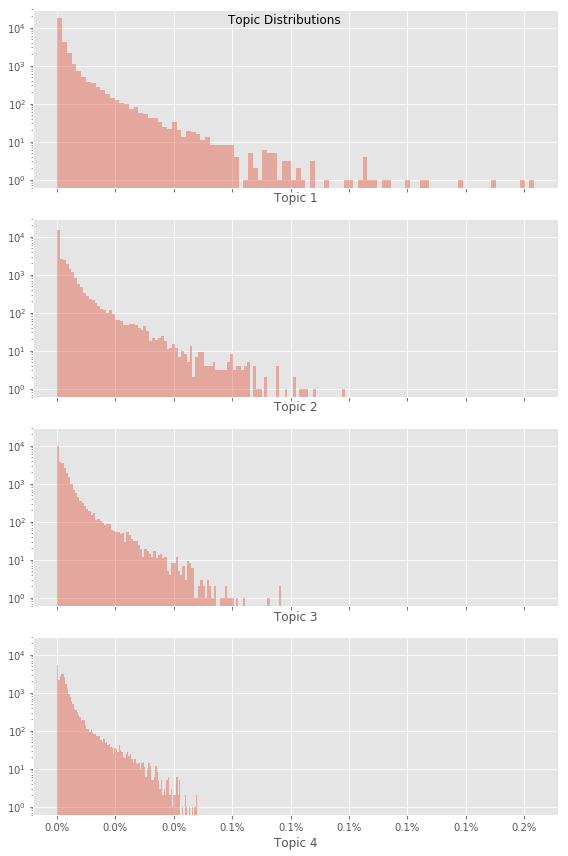

In [50]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(8,12))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

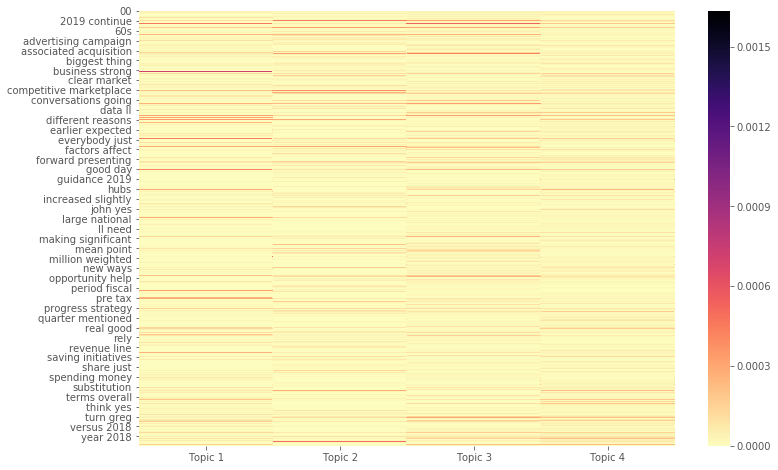

In [51]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (4)

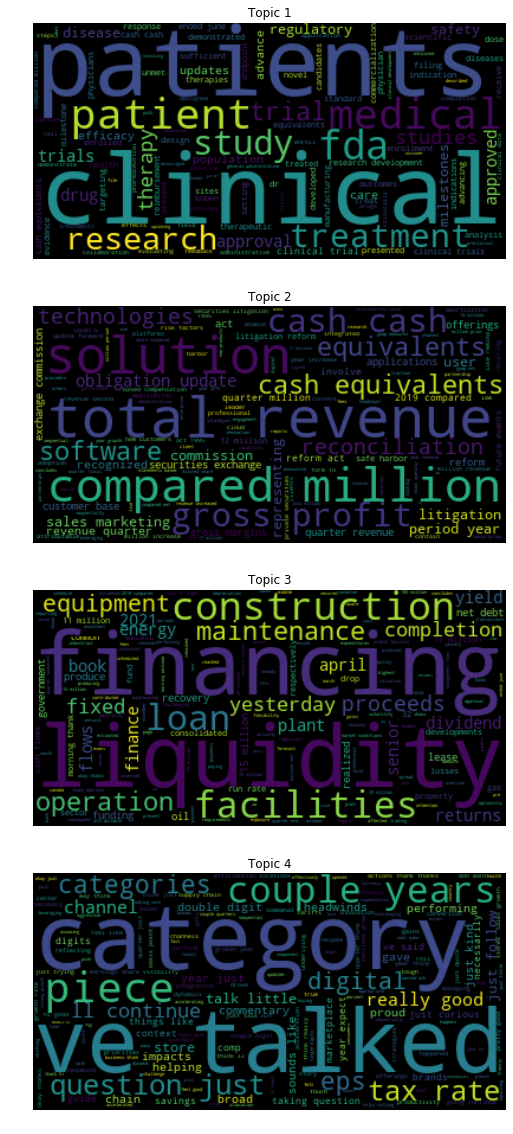

In [52]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(10,20))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (4)

In [53]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(1335, 4)

In [54]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [55]:
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4
0,0.00,0.00,0.59,0.40
1,0.00,0.64,0.13,0.23
2,0.00,0.23,0.00,0.77
3,0.00,0.10,0.09,0.81
4,0.00,0.28,0.22,0.51


In [56]:
test_preds = lda_base.transform(test_dtm)
test_preds.shape

(50, 4)

In [57]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4
0,0.00,0.27,0.38,0.35
1,0.00,0.01,0.60,0.39
2,0.44,0.43,0.06,0.08
3,0.00,0.30,0.03,0.67
4,0.52,0.09,0.11,0.27


### Perplexity (4)

In [58]:
lda_base.perplexity(train_dtm)

18558.965482787047

In [59]:
lda_base.perplexity(test_dtm)

459958.45669131656

### Cluster Graphs using PyLDAvis.prepare (4)

In [60]:
prepare(lda_base, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
3     -0.07 -0.08       1        1 41.56
2     -0.06 -0.04       2        1 28.51
1      0.17 -0.02       3        1 20.96
0     -0.04  0.14       4        1  8.97, topic_info=      Category  Freq                  Term  Total  loglift  logprob
4636   Default  7.00              clinical   7.00    30.00    30.00
18208  Default  7.00              patients   7.00    29.00    29.00
18202  Default  8.00               patient   8.00    28.00    28.00
15869  Default  9.00               medical   9.00    27.00    27.00
21968  Default 13.00              research  13.00    26.00    26.00
24931  Default  8.00                 study   8.00    25.00    25.00
26864  Default  8.00             treatment   8.00    24.00    24.00
2411   Default 10.00              approval  10.00    23.00    23.00
9321   Default  5.00                   fda   5.00    22.00    22.00
2415   Default 11.00              approved  11.00    21.00    21.00
21551  Default 13.00            regulatory  13.00    20.00    20.00
26900  Default  7.00                 trial   7.00    19.00    19.00
4231   Default 13.00      cash equivalents  13.00    18.00    18.00
8459   Default 13.00           equivalents  13.00    17.00    17.00
26720  Default 11.00         total revenue  11.00    16.00    16.00
22780  Default  9.00                safety   9.00    15.00    15.00
4218   Default 13.00             cash cash  13.00    14.00    14.00
24928  Default  6.00               studies   6.00    13.00    13.00
5209   Default 14.00      compared million  14.00    12.00    12.00
26905  Default  5.00                trials   5.00    11.00    11.00
7865   Default  4.00                  drug   4.00    10.00    10.00
25894  Default  4.00               therapy   4.00     9.00     9.00
8290   Default 12.00            ended june  12.00     8.00     8.00
16055  Default  7.00            milestones   7.00     7.00     7.00
7449   Default  4.00               disease   4.00     6.00     6.00
18874  Default  7.00            population   7.00     5.00     5.00
21969  Default  6.00  research development   6.00     4.00     4.00
27259  Default 11.00               updates  11.00     3.00     3.00
24137  Default 10.00              software  10.00     2.00     2.00
4178   Default 12.00                  care  12.00     1.00     1.00
...        ...   ...                   ...    ...      ...      ...
7865    Topic4  4.54                  drug   4.87     2.34    -6.86
18550   Topic4  2.62             physician   2.74     2.37    -7.41
7868    Topic4  2.48                 drugs   2.61     2.36    -7.47
17221   Topic4  2.67                 novel   2.84     2.35    -7.39
26868   Topic4  2.38            treatments   2.50     2.36    -7.51
23171   Topic4  3.41            scientific   3.78     2.31    -7.14
8105    Topic4  3.67              efficacy   4.14     2.29    -7.07
18202   Topic4  6.49               patient   8.27     2.17    -6.50
4062    Topic4  3.07                cancer   3.43     2.30    -7.25
26905   Topic4  4.58                trials   5.93     2.15    -6.85
8349    Topic4  3.29            enrollment   3.94     2.23    -7.18
15869   Topic4  6.00               medical   9.01     2.00    -6.58
24928   Topic4  4.70               studies   6.46     2.09    -6.83
24931   Topic4  5.43                 study   8.60     1.95    -6.68
26900   Topic4  4.82                 trial   7.41     1.98    -6.80
26864   Topic4  5.23             treatment   8.77     1.89    -6.72
21562   Topic4  2.87         reimbursement   3.31     2.27    -7.32
7737    Topic4  3.46                    dr   4.89     2.07    -7.13
26860   Topic4  3.24               treated   4.36     2.11    -7.20
2411    Topic4  4.59              approval  10.40     1.59    -6.85
16055   Topic4  3.99            milestones   7.41     1.79    -6.99
21968   Topic4  4.92              research  13.57     1.40    -6.78
22780   Topic4  4.27                saf

## 5. Use 3 Topics

### lda_base model with 'batch' method (3)

In [61]:
n_components = 3

In [62]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1)
lda_base.fit(train_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 18748.9817
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 18607.9108
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 18591.0661
iterati

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [63]:
topics_count = lda_base.components_

In [64]:
topics_count.shape

(3, 28923)

In [65]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[3.62621132e-05, 1.15945337e-05, 2.98350080e-05, ...,
        3.06484916e-05, 1.82575707e-06, 1.85610497e-06],
       [2.83626570e-05, 3.48342923e-05, 1.16743652e-05, ...,
        1.35841015e-04, 8.75281633e-05, 3.23834052e-05],
       [3.56570853e-05, 2.07444630e-05, 1.22313383e-05, ...,
        9.74024523e-06, 4.16132003e-06, 5.06897907e-07]])

In [66]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3
00,0.00,0.00,0.00
000 000,0.00,0.00,0.00
000 01,0.00,0.00,0.00
000 02,0.00,0.00,0.00
000 10,0.00,0.00,0.00


In [67]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3
0,research,construction,digital
1,patients,liquidity,channel
2,medical,financing,offerings
3,ended june,facilities,category
4,compared million,loan,gross margins
5,clinical,dividend,integration
6,cash equivalents,maintenance,innovation
7,equivalents,operation,channels
8,cash cash,fixed,win
9,patient,equipment,reconciliation


### Topics Distributions & Heatmap (3)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


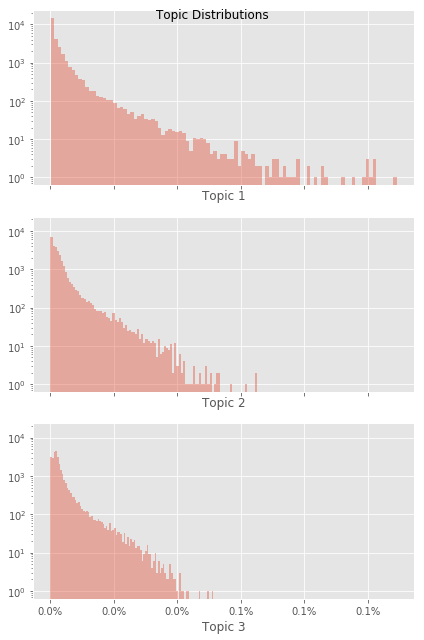

In [68]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(6,9))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

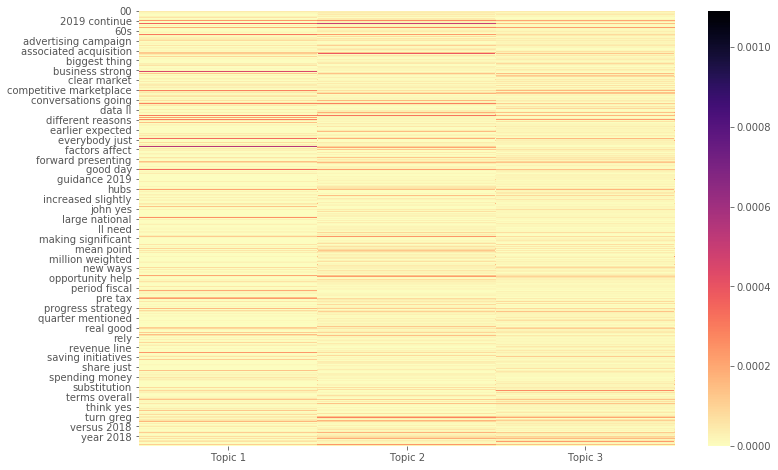

In [69]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (3)

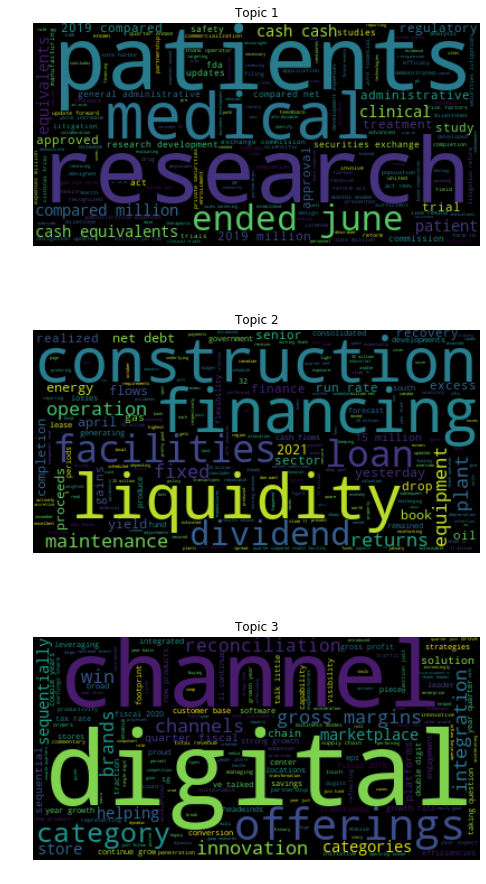

In [70]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(8,16))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (3)

In [71]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(1335, 3)

In [72]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [73]:
train_eval.head()

,Topic 1,Topic 2,Topic 3
0,0.00,0.70,0.29
1,0.18,0.05,0.76
2,0.00,0.00,1.00
3,0.00,0.09,0.91
4,0.03,0.25,0.73


In [74]:
test_preds = lda_base.transform(test_dtm)
test_preds.shape

(50, 3)

In [75]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2,Topic 3
0,0.14,0.40,0.46
1,0.00,0.77,0.23
2,0.69,0.01,0.30
3,0.02,0.03,0.95
4,0.58,0.11,0.31


### Perplexity (3)

In [76]:
lda_base.perplexity(train_dtm)

18580.326846390533

In [77]:
lda_base.perplexity(test_dtm)

241312.0367484923

### Cluster Graphs using PyLDAvis.prepare (3)

In [78]:
prepare(lda_base, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2     -0.07  0.07       1        1 52.76
1     -0.05 -0.07       2        1 31.40
0      0.12  0.01       3        1 15.83, topic_info=      Category  Freq                     Term  Total  loglift  logprob
21968  Default 13.00                 research  13.00    30.00    30.00
18208  Default  7.00                 patients   7.00    29.00    29.00
4636   Default  7.00                 clinical   7.00    28.00    28.00
15869  Default  9.00                  medical   9.00    27.00    27.00
8290   Default 12.00               ended june  12.00    26.00    26.00
4231   Default 13.00         cash equivalents  13.00    25.00    25.00
8459   Default 13.00              equivalents  13.00    24.00    24.00
4218   Default 13.00                cash cash  13.00    23.00    23.00
18202  Default  8.00                  patient   8.00    22.00    22.00
5209   Default 13.00         compared million  13.00    21.00    21.00
652    Default 13.00            2019 compared  13.00    20.00    20.00
24931  Default  8.00                    study   8.00    19.00    19.00
726    Default  8.00             2019 million   8.00    18.00    18.00
26900  Default  7.00                    trial   7.00    17.00    17.00
2415   Default 12.00                 approved  12.00    16.00    16.00
21551  Default 13.00               regulatory  13.00    15.00    15.00
2411   Default 10.00                 approval  10.00    14.00    14.00
21969  Default  7.00     research development   7.00    13.00    13.00
9321   Default  5.00                      fda   5.00    12.00    12.00
26864  Default  9.00                treatment   9.00    11.00    11.00
10146  Default  8.00   general administrative   8.00    10.00    10.00
26905  Default  6.00                   trials   6.00     9.00     9.00
1932   Default 12.00           administrative  12.00     8.00     8.00
24928  Default  6.00                  studies   6.00     7.00     7.00
23263  Default  9.00      securities exchange   9.00     6.00     6.00
5212   Default  9.00             compared net   9.00     5.00     5.00
22780  Default  9.00                   safety   9.00     4.00     4.00
8622   Default  9.00      exchange commission   9.00     3.00     3.00
25894  Default  4.00                  therapy   4.00     2.00     2.00
27259  Default 11.00                  updates  11.00     1.00     1.00
...        ...   ...                      ...    ...      ...      ...
18202   Topic3  7.30                  patient   8.75     1.66    -6.95
26905   Topic3  5.36                   trials   6.23     1.69    -7.26
21969   Topic3  5.97     research development   7.17     1.66    -7.15
7737    Topic3  4.47                       dr   5.12     1.71    -7.44
24928   Topic3  5.50                  studies   6.76     1.64    -7.24
726     Topic3  6.37             2019 million   8.29     1.58    -7.09
26900   Topic3  5.97                    trial   7.78     1.58    -7.15
24931   Topic3  6.57                    study   8.96     1.53    -7.06
4936    Topic3  3.98        commercialization   4.61     1.70    -7.56
21968   Topic3  8.33                 research  13.79     1.34    -6.82
26864   Topic3  6.25                treatment   9.09     1.47    -7.11
8290    Topic3  7.75               ended june  12.90     1.33    -6.89
4231    Topic3  7.61         cash equivalents  13.07     1.30    -6.91
8459    Topic3  7.61              equivalents  13.55     1.27    -6.91
5209    Topic3  7.71         compared million  13.92     1.25    -6.90
4218    Topic3  7.57                cash cash  13.76     1.25    -6.92
10146   Topic3  5.77   general administrative   8.99     1.40    -7.19
652     Topic3  7.03            2019 compared  13.39     1.20    -6.99
2411    Topic3  6.21                 approval  10.60     1.31    -7.12
2415    Topic3  6.55                 approved  12.05     1.23    -7.06
21551   Topic3  6.63               regulatory  13.13     1.1

## 6. Use 2 Topics

### lda_base model with 'batch' method (2)

In [79]:
n_components = 2

In [80]:
lda_base = LatentDirichletAllocation(n_components = n_components,
                                     learning_method = 'batch',
                                     max_iter = 100,
                                     evaluate_every=10,
                                     verbose = 1)
lda_base.fit(train_dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 18778.2569
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 18743.6872
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 18738.4158
iterati

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [81]:
topics_count = lda_base.components_

In [82]:
topics_count.shape

(2, 28923)

In [83]:
topics_prob = topics_count/topics_count.sum(axis=1).reshape(-1,1)
topics_prob

array([[4.65332807e-05, 2.49475776e-05, 3.61532430e-05, ...,
        9.65608309e-05, 9.02776907e-05, 1.09481482e-05],
       [2.91466206e-05, 2.36485251e-05, 7.50248691e-06, ...,
        3.88786039e-05, 1.10936120e-05, 1.08765085e-05]])

In [84]:
topic_labels = ['Topic {}'.format(i) for i in range(1,n_components+1)]
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2
00,0.00,0.00
000 000,0.00,0.00
000 01,0.00,0.00
000 02,0.00,0.00
000 10,0.00,0.00


In [85]:
# compute the words with the 20 highest probabilities in each topic
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2
0,ended june,digital
1,2019 compared,channel
2,compared million,couple years
3,approved,piece
4,research,savings
5,regulatory,offerings
6,cash cash,gains
7,equivalents,category
8,financing,reconciliation
9,approval,performing


### Topics Distributions & Heatmap (2)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


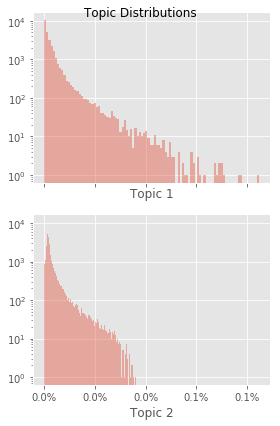

In [86]:
fig, axes = plt.subplots(nrows=n_components,sharey=True,sharex=True,figsize=(4,6))

for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob,ax=axes[i],bins=100,kde=False,norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x,_:'{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

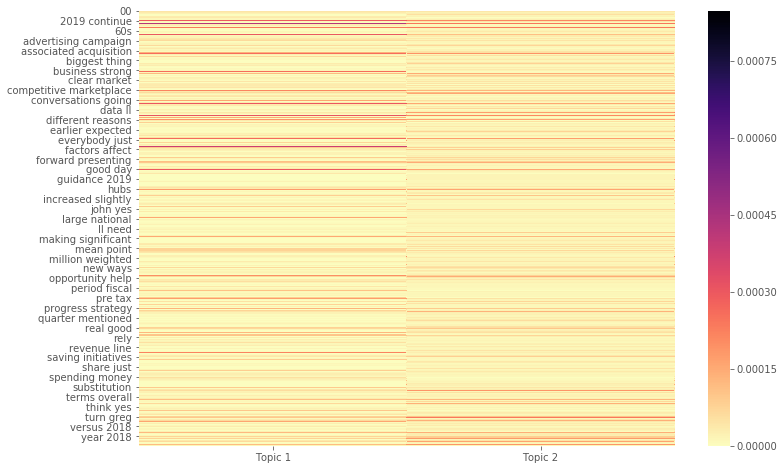

In [87]:
plt.figure(figsize=(12,8))
sns.heatmap(topics, cmap='magma_r');

### Word Cloud (2)

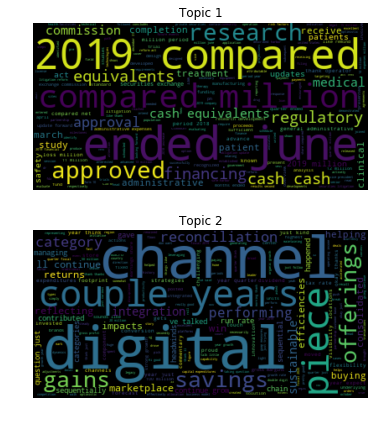

In [97]:
w = WordCloud()
fig, axes = plt.subplots(nrows= n_components, figsize=(6,7))
axes = axes.flatten()
for t,(topic,freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w,interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')

### Predictions (2)

In [89]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(1335, 2)

In [90]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels)

In [91]:
train_eval.head()

,Topic 1,Topic 2
0,0.09,0.91
1,0.25,0.75
2,0.00,1.00
3,0.00,1.00
4,0.06,0.94


In [92]:
test_preds = lda_base.transform(test_dtm)
test_preds.shape

(50, 2)

In [93]:
test_eval = pd.DataFrame(test_preds, columns=topic_labels)
test_eval.head()

,Topic 1,Topic 2
0,0.34,0.66
1,0.28,0.72
2,0.78,0.22
3,0.01,0.99
4,0.65,0.35


### Perplexity (2)

In [94]:
lda_base.perplexity(train_dtm)

18733.49465751523

In [95]:
lda_base.perplexity(test_dtm)

109513.12386992866

### Cluster Graphs using PyLDAvis.prepare (2)

In [98]:
prepare(lda_base, test_dtm, vectorizer)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=          x    y  topics  cluster  Freq
topic                                  
1      0.07 0.00       1        1 73.31
0     -0.07 0.00       2        1 26.69, topic_info=      Category  Freq                     Term  Total  loglift  logprob
8290   Default 12.00               ended june  12.00    30.00    30.00
652    Default 13.00            2019 compared  13.00    29.00    29.00
5209   Default 13.00         compared million  13.00    28.00    28.00
2415   Default 12.00                 approved  12.00    27.00    27.00
2411   Default 10.00                 approval  10.00    26.00    26.00
21551  Default 13.00               regulatory  13.00    25.00    25.00
21968  Default 13.00                 research  13.00    24.00    24.00
15869  Default  9.00                  medical   9.00    23.00    23.00
4636   Default  7.00                 clinical   7.00    22.00    22.00
4218   Default 13.00                cash cash  13.00    21.00    21.00
8459   Default 13.00              equivalents  13.00    20.00    20.00
18208  Default  7.00                 patients   7.00    19.00    19.00
4231   Default 12.00         cash equivalents  12.00    18.00    18.00
26864  Default  9.00                treatment   9.00    17.00    17.00
9491   Default 14.00                financing  14.00    16.00    16.00
18202  Default  8.00                  patient   8.00    15.00    15.00
24931  Default  8.00                    study   8.00    14.00    14.00
726    Default  8.00             2019 million   8.00    13.00    13.00
1932   Default 12.00           administrative  12.00    12.00    12.00
4941   Default 12.00               commission  12.00    11.00    11.00
22780  Default  9.00                   safety   9.00    10.00    10.00
5302   Default 12.00               completion  12.00     9.00     9.00
21267  Default 12.00                  receive  12.00     8.00     8.00
10146  Default  8.00   general administrative   8.00     7.00     7.00
5212   Default  9.00             compared net   9.00     6.00     6.00
16639  Default  7.00             months ended   7.00     5.00     5.00
18412  Default  7.00              period 2018   7.00     4.00     4.00
23263  Default  9.00      securities exchange   9.00     3.00     3.00
15216  Default 13.00                    march  13.00     2.00     2.00
16354  Default  8.00           million period   8.00     1.00     1.00
...        ...   ...                      ...    ...      ...      ...
16639   Topic2  6.42             months ended   7.40     1.18    -7.60
26905   Topic2  5.40                   trials   6.06     1.21    -7.78
2411    Topic2  8.66                 approval  10.63     1.12    -7.30
21969   Topic2  6.08     research development   6.99     1.18    -7.66
652     Topic2  9.98            2019 compared  13.43     1.02    -7.16
2415    Topic2  9.10                 approved  12.08     1.04    -7.26
18412   Topic2  6.46              period 2018   7.84     1.13    -7.60
5209    Topic2  9.89         compared million  13.86     0.98    -7.17
10146   Topic2  6.86   general administrative   8.91     1.06    -7.54
25031   Topic2  5.89               sufficient   7.20     1.12    -7.69
21551   Topic2  9.01               regulatory  13.12     0.95    -7.26
6750    Topic2  5.27              december 31   6.18     1.16    -7.80
22780   Topic2  7.28                   safety   9.87     1.02    -7.48
1935    Topic2  6.25  administrative expenses   7.92     1.08    -7.63
21968   Topic2  9.05                 research  13.57     0.92    -7.26
5212    Topic2  6.84             compared net   9.04     1.04    -7.54
4231    Topic2  8.64         cash equivalents  12.91     0.92    -7.31
8459    Topic2  8.86              equivalents  13.41     0.91    -7.28
4218    Topic2  8.92                cash cash  13.62     0.90    -7.27
9491    Topic2  8.77                financing  14.01     0.85    -7.29
1932    Topic2  7.81           administrative  12.14     0.88    -7.41
16354   Topic2  6.59           mil

## Results:

According to the results of perplexities, the model with 3 or 4 topics have the lowest training perplexity.

And we can see from the word cloud that the clusters with 3 topics makes more sense, which well seperates the documents of the training data into 3 main reasonable topics: "medical", "financing", and "digital". And its cluster graphs using PyLDAvis package also shows that it can well seperate the documents of the test data.

Therefore, we can conclude that the topics make sense as a way to cluster the documents, and the documents can be clustered into 3 main clusters regarding the topics: "medical", "financing", and "digital".